In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import cftime

import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os
import warnings
warnings.simplefilter("ignore") 

import cosima_cookbook as cc

from dask.distributed import Client

In [2]:
session = cc.database.create_session()

In [13]:
# Define experiment dictionary
from collections import OrderedDict
exptdict = OrderedDict([
    ('025degIAF', {'model':'ACCESS-OM2-025 IAF', 'expt':'025deg_jra55v13_iaf_gmredi6', # 025deg IAF run from Kiss et al. 2020
                'n_files':-1, 'itime':pd.datetime(1998,1,1),'ftime':None}),
    ('01degIAF',  {'model':'ACCESS-OM2-01 IAF',  'expt':'01deg_jra55v13_iaf', # 01deg IAF run from Kiss et al. 2020
                'n_files':-4, 'itime':pd.datetime(1998,1,1),'ftime':None}),
    ('01degRYF',  {'model':'ACCESS-OM2-01 CTRL',  'expt':'01deg_jra55v13_ryf9091', # 01deg RYF run (Qian's control)
                'n_files':-4, 'itime': '2110-01-01','ftime':'2160-01-01'}),
    ('Qian_ctrl', {'model':'ACCESS-OM2-01 CTRL', 'expt':'01deg_jra55v13_ryf9091_qian_ctrl', # 01deg Control from Li et al. 2022 
                   'n_files':None, 'itime': '2110-01-01','ftime':'2160-01-01'}),
    ('Qian_pert', {'model':'ACCESS-OM2-01 Future', 'expt':'01deg_jra55v13_ryf9091_qian_wthmp', # 01deg Full future projection from Li et al. 2022
                   'n_files':None, 'itime': '2110-01-01','ftime':'2160-01-01'}),
])

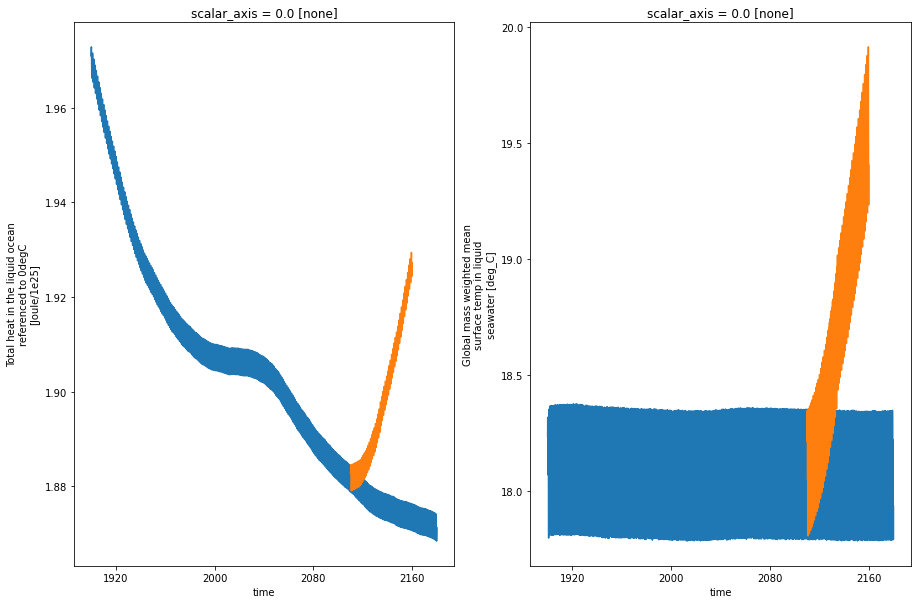

In [12]:
# Scalar global OHC and SST (for check):
key = '01degRYF'
CTRL_gohc= cc.querying.getvar(exptdict[key]['expt'], 'total_ocean_heat', session,start_time=exptdict[key]['itime'],end_time=exptdict[key]['ftime'])
CTRL_gsst= cc.querying.getvar(exptdict[key]['expt'], 'temp_surface_ave', session,start_time=exptdict[key]['itime'],end_time=exptdict[key]['ftime'])
key = 'Qian_pert'
PERT_gohc= cc.querying.getvar(exptdict[key]['expt'], 'total_ocean_heat', session,start_time=exptdict[key]['itime'],end_time=exptdict[key]['ftime'])
PERT_gsst= cc.querying.getvar(exptdict[key]['expt'], 'temp_surface_ave', session,start_time=exptdict[key]['itime'],end_time=exptdict[key]['ftime'])

plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
CTRL_gohc.plot()
PERT_gohc.plot()

plt.subplot(1,2,2)
CTRL_gsst.plot()
PERT_gsst.plot()

In [14]:
def plot_box(lons,lats,col):
    plt.plot([lons[0], lons[1], lons[1],lons[0],lons[0]],[lats[0],lats[0],lats[1],lats[1],lats[0]],'-' + col)

In [23]:
# Define maximum GBR region:
GBRlats = -27.5, -10.
GBRlons = -217.5, -205.

SGBRlats = -24.5, -22.
SGBRlons = -208., -206.8

NGBRlats = -15., -12.
NGBRlons = -217., -214.5

In [18]:
# GBR averaged SST trends:
# CTRL_SST = cc.querying.getvar(exptdict['01degRYF']['expt'], 'surface_temp', session, frequency='1 monthly')
key = 'Qian_pert'
PERT_SST = cc.querying.getvar(exptdict[key]['expt'], 'surface_temp', session, frequency='1 monthly',start_time=exptdict[key]['itime'],end_time=exptdict[key]['ftime']).sel(xt_ocean=slice(GBRlons[0],GBRlons[1])).sel(yt_ocean=slice(GBRlats[0],GBRlats[1]))-273.15

<xarray.DataArray 'time' (time: 600)>
array([cftime.DatetimeNoLeap(2110, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2110, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2110, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2159, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2159, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2159, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
Attributes:
    long_name:       time
    cartesian_axis:  T
    calendar_type:   NOLEAP
    bounds:          time_bounds

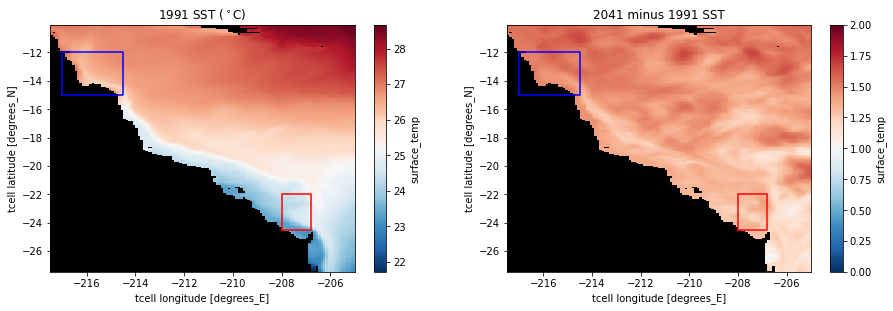

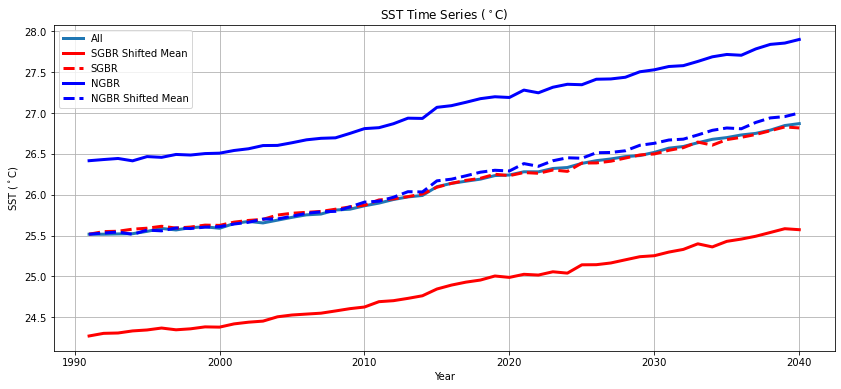

In [37]:
fig = plt.figure(figsize=(15,10),facecolor='w')

plt.subplot(2,2,1)
PERT_SST.isel(time=slice(0,12)).mean('time').plot(cmap='RdBu_r')
plot_box(SGBRlons,SGBRlats,'r')
plot_box(NGBRlons,NGBRlats,'b')
plt.title('1991 SST ($^\circ$C)')
plt.gca().set_facecolor('k')

plt.subplot(2,2,2)
(PERT_SST.isel(time=slice(-13,-1)).mean('time')-PERT_SST.isel(time=slice(0,12)).mean('time')).plot(vmin=0.,vmax=2.,cmap='RdBu_r') # Replace with linear trend.
plot_box(SGBRlons,SGBRlats,'r')
plot_box(NGBRlons,NGBRlats,'b')
plt.title('2041 minus 1991 SST')
plt.gca().set_facecolor('k')

fig = plt.figure(figsize=(14,6),facecolor='w')
TS = PERT_SST.mean('xt_ocean').mean('yt_ocean').resample(time='1A').mean()
tvec = np.arange(1991,2041)
plt.plot(tvec,TS,label='All',linewidth=3.)
TS1 = PERT_SST.sel(xt_ocean=slice(SGBRlons[0],SGBRlons[1])).sel(yt_ocean=slice(SGBRlats[0],SGBRlats[1])).mean('xt_ocean').mean('yt_ocean').resample(time='1A').mean()
plt.plot(tvec,TS1,color='r',label='SGBR Shifted Mean',linewidth=3.)
plt.plot(tvec,(TS1-TS1[0]+TS[0]),color='r',label='SGBR',linestyle='dashed',linewidth=3.)
TS2 = PERT_SST.sel(xt_ocean=slice(NGBRlons[0],NGBRlons[1])).sel(yt_ocean=slice(NGBRlats[0],NGBRlats[1])).mean('xt_ocean').mean('yt_ocean').resample(time='1A').mean()
plt.plot(tvec,TS2,color='b',label='NGBR',linewidth=3.)
plt.plot(tvec,(TS2-TS2[0]+TS[0]),color='b',label='NGBR Shifted Mean',linestyle='dashed',linewidth=3.)
plt.legend()
plt.xlabel('Year')
plt.ylabel('SST ($^\circ$C)')
plt.title('SST Time Series ($^\circ$C)')
plt.grid()

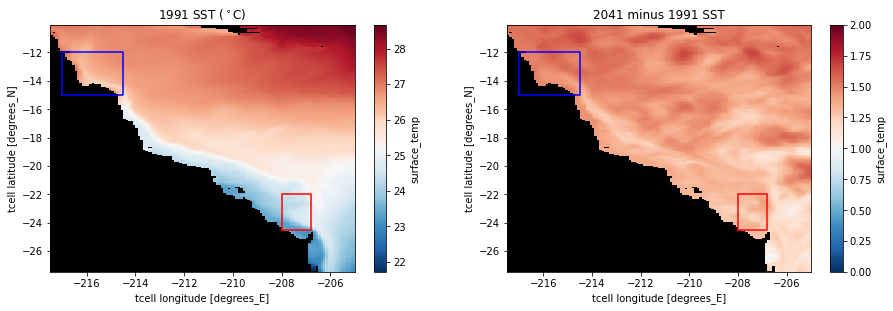

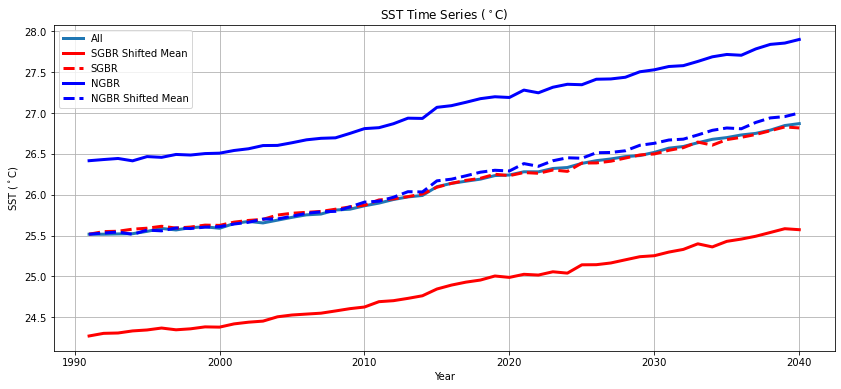

In [37]:
fig = plt.figure(figsize=(15,10),facecolor='w')

plt.subplot(2,2,1)
PERT_SST.isel(time=slice(0,12)).mean('time').plot(cmap='RdBu_r')
plot_box(SGBRlons,SGBRlats,'r')
plot_box(NGBRlons,NGBRlats,'b')
plt.title('1991 SST ($^\circ$C)')
plt.gca().set_facecolor('k')

plt.subplot(2,2,2)
(PERT_SST.isel(time=slice(-13,-1)).mean('time')-PERT_SST.isel(time=slice(0,12)).mean('time')).plot(vmin=0.,vmax=2.,cmap='RdBu_r') # Replace with linear trend.
plot_box(SGBRlons,SGBRlats,'r')
plot_box(NGBRlons,NGBRlats,'b')
plt.title('2041 minus 1991 SST')
plt.gca().set_facecolor('k')

fig = plt.figure(figsize=(14,6),facecolor='w')
TS = PERT_SST.mean('xt_ocean').mean('yt_ocean').resample(time='1A').mean()
tvec = np.arange(1991,2041)
plt.plot(tvec,TS,label='All',linewidth=3.)
TS1 = PERT_SST.sel(xt_ocean=slice(SGBRlons[0],SGBRlons[1])).sel(yt_ocean=slice(SGBRlats[0],SGBRlats[1])).mean('xt_ocean').mean('yt_ocean').resample(time='1A').mean()
plt.plot(tvec,TS1,color='r',label='SGBR Shifted Mean',linewidth=3.)
plt.plot(tvec,(TS1-TS1[0]+TS[0]),color='r',label='SGBR',linestyle='dashed',linewidth=3.)
TS2 = PERT_SST.sel(xt_ocean=slice(NGBRlons[0],NGBRlons[1])).sel(yt_ocean=slice(NGBRlats[0],NGBRlats[1])).mean('xt_ocean').mean('yt_ocean').resample(time='1A').mean()
plt.plot(tvec,TS2,color='b',label='NGBR',linewidth=3.)
plt.plot(tvec,(TS2-TS2[0]+TS[0]),color='b',label='NGBR Shifted Mean',linestyle='dashed',linewidth=3.)
plt.legend()
plt.xlabel('Year')
plt.ylabel('SST ($^\circ$C)')
plt.title('SST Time Series ($^\circ$C)')
plt.grid()

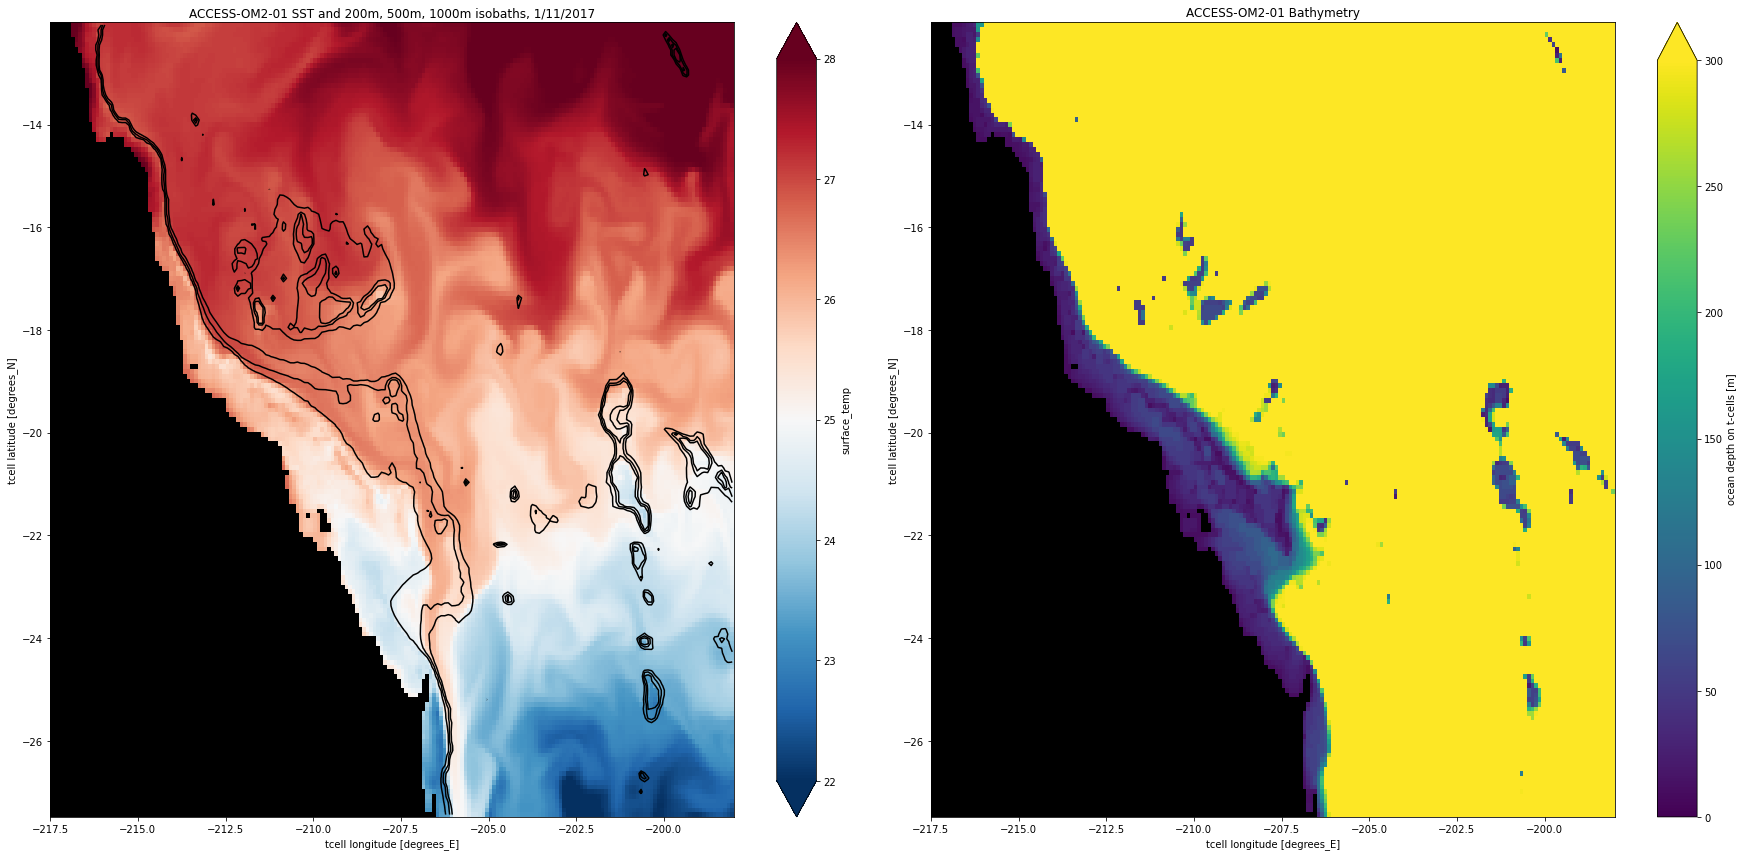

In [42]:
fig = plt.figure(figsize=(25,12),facecolor='w')

keys = ['01degIAF']#,'025degIAF','01degIAF']
for i, key in enumerate(keys):
    ax = plt.subplot(1,2,1)
    
    var = cc.querying.getvar(exptdict[key]['expt'], 'surface_temp',session, frequency='1 daily',n=exptdict[key]['n_files'],
                             start_time=exptdict[key]['itime'],end_time=exptdict[key]['ftime']).sel(xt_ocean=slice(-217.5,-198)).sel(yt_ocean=slice(-27.5,-12.))
    h = cc.querying.getvar(exptdict[key]['expt'], 'ht',session,n=-1).sel(xt_ocean=slice(-217.5,-198)).sel(yt_ocean=slice(-27.5,-12.))
    var = var.sel(time='2017-11-01')-273.15
    var.plot(ax=ax,vmin=22.,vmax=28.,cmap='RdBu_r')
    h.plot.contour(levels=[200.,500.,1000.],colors='k')
    ax.set_facecolor('k')
    ax.set_title('ACCESS-OM2-01 SST and 200m, 500m, 1000m isobaths, 1/11/2017')
    
    
    ax = plt.subplot(1,2,2)
    h.plot(ax=ax,vmin=0.,vmax=300.)
    ax.set_facecolor('k')
    ax.set_title('ACCESS-OM2-01 Bathymetry')

plt.tight_layout()
plt.savefig('GBR_SST_ACCESS-OM2-01.png',dpi=150)